# Analyze Mrk 421 flare from 1996-05-07

Example of how to use the Whipple raw data archive to reproduce the analysis of the large flare form the AGN Markarian 421 described by [Gaidos, J.A. et al., Nature **383**, 319 (1996)](https://www.nature.com/articles/383319a0). The notebook

- downloads and prints the logsheet from the night to display the comments from the observers
- downloads and prints the summary information for the runs
- downloads the raw data for the flare, and the flat-fielding calibration run (the *Nitrogen* run)
- calculates the pedestal value and sky noise for the night
- calculates the gain and flat-fielding correction values
- calculates the Hillas parameters for the events
- implements a "Supercuts" to select gamma-ray events
- displays an *alpha plot* to vistalize the excess from the source

In [1]:
%matplotlib inline
import sys
import fzreader
import numpy
import matplotlib.pyplot

## Connect to the Whipple archive, either the Harvard dataverse or Zenodo

In [2]:
# archive = fzreader.FZDataArchive('harvard', verbose=True)
archive = fzreader.FZDataArchive('zenodo', verbose=True)

[FZDataArchive] Downloading index.json from https://zenodo.org/records/16890876/files/index.json?download=1
[FZDataArchive] Downloading raw10_index.csv.xz from https://zenodo.org/records/16890876/files/raw10_index.csv.xz?download=1
Archive: Raw data from the Whipple 10m gamma-ray telescope, Mt Hopkins, AZ
Provider: Zenodo (10.5281/zenodo.16890876) | Runs: 22772 files / 186.51 GB


## Print the logsheet for the night

Here you can see the observers started with a Nitrogen calibration run and then switched to Markarian 421, planning to take an *on/off* pair of runs. They started the *off* run and took data for 10 minutes while processing the on-source data using the Quicklook analysis. When they saw the large rate they aborted the *off* run and took *tracking* data on Mrk421 for the rest of the night. The obsrevers report a total significance of >56 sigma on the source using the Quicklook analysis.

In [3]:
print(archive.get_logsheet_by_date('19960507'))

[FZDataArchive] Downloading log10_index.csv.xz from https://zenodo.org/records/16890876/files/log10_index.csv.xz?download=1
[FZDataArchive] Fetching log10/d19960507.log_10 from log10.tar [702976-704285]
UTDATE 960507           10M LOG
    10M  
ID  RUN   Source     SID     UTC    DUR  MODE  SKY   PNT    Comments
N2  5105  Nitrogen  11:08   3:30     2   trk
M4  5106  Mrk421    11:12   3:35    28   on     1    Y(1)  PMT 16**
M4  5107  Mrk421    11:43   4:05    10   off    1           ditto
M4  5108  Mrk421    11:56   4:18    28   trk    1    Y(1)   ditto
M4  5109  Mrk421    12:25   4:47    28   trk    1    Y(1)   ditto
M4  5110  Mrk421    12:54   5:16    28   trk    1    Y(1)   ditto
M4  5111  Mrk421    13:22   5:44     5   trk    1    Y(1)  PMT 16 OK
Observer: ##### ##### ##### 
SKY: Beautiful night - excellent seeing. Welcome to all our visitors
Comments:  

  Just take a look at 421 folks - we can barely see the stars!

  **PMT 16 current <1/2 that in neighbouring tubes.

Discriminato

# Make the run list

In [4]:
n2run = 5105
m4runs = [ 5106, 5108, 5109, 5110, 5111 ]

# Get the run summary information and print some info for the user

In [5]:
run_db = archive.get_run_summary_database_as_dict()

[FZDataArchive] Downloading raw10_run_summary.csv.xz from https://zenodo.org/records/16890876/files/raw10_run_summary.csv.xz?download=1


In [6]:
n2info = run_db[n2run]
m4info = [run_db[r] for r in m4runs]

In [7]:
for ri in m4info:
    print(f'{ri["filename"]} : el={ri["el_min"]}->{ri["el_max"]}, nev={ri["nevent"]}, dur={ri["duration"]} sec')

raw10/d19960507/gt005106.fz.xz : el=80.36->83.15, nev=24235, dur=1677 sec
raw10/d19960507/gt005108.fz.xz : el=72.73->77.27, nev=24000, dur=1675 sec
raw10/d19960507/gt005109.fz.xz : el=66.95->72.22, nev=24600, dur=1675 sec
raw10/d19960507/gt005110.fz.xz : el=61.32->66.41, nev=23952, dur=1675 sec
raw10/d19960507/gt005111.fz.xz : el=59.98->60.78, nev=4988, dur=334 sec


# Get the camera geometry

We use the `nadc` from the Nitrogen run information to get the correct camera configuration for these runs. We also convert the `x` and `y` elements of the camera from a list to a numpy array (since the base FZ library doesn't assume numpy is present).

In [8]:
camera = fzreader.get_camera_geometry_by_nadc(n2info['nadc'])
camera['x'] = numpy.asarray(camera['x'])
camera['y'] = numpy.asarray(camera['y'])

# Download the data from the archive

In [9]:
n2data = archive.get_run_by_number(n2run)
m4data = [ archive.get_run_by_number(x) for x in m4runs ]

[FZDataArchive] Fetching raw10/d19960507/gt005105.fz.xz from raw10_1995_1996.tar [2488412672-2488798767]
[FZDataArchive] Fetching raw10/d19960507/gt005106.fz.xz from raw10_1995_1996.tar [2494007808-2497306435]
[FZDataArchive] Fetching raw10/d19960507/gt005108.fz.xz from raw10_1995_1996.tar [2490775552-2494006903]
[FZDataArchive] Fetching raw10/d19960507/gt005109.fz.xz from raw10_1995_1996.tar [2497307136-2500600687]
[FZDataArchive] Fetching raw10/d19960507/gt005110.fz.xz from raw10_1995_1996.tar [2500601344-2503828979]
[FZDataArchive] Fetching raw10/d19960507/gt005111.fz.xz from raw10_1995_1996.tar [2488799744-2489489955]


# Calculate the pedestals

The following function loops through all events to calculate the pedestal mean and RMS. It can be chanined to average over multiple runs.

We calculate the pedestals in two passes, the first pass uses all of the periodic *pedestal* events. The second pass filters only events that have less than a 4-sigma fluctuation. In fact, here, this make no difference, but it is prudent.

In [10]:
def calc_ped(fzdata, camera=None, nped=0, ped_val=0, ped_rms=0, adc_threshold=numpy.inf, max_nadc_above_adc_threshold=numpy.inf):
    # Calculate pedestal mean and rms, allowing chaining of data runs
    ped_sum = ped_val*nped
    ped_sum_sq = (ped_rms**2 + ped_val**2)*nped
    with fzreader.FZReader(fzdata) as fz:
        for r in fz:
            if fzreader.is_pedestal_event(r):
                adc = numpy.asarray(r['adc_values'])
                if camera:
                    adc = adc[:camera['npix']]
                if(numpy.count_nonzero(adc>adc_threshold)>=max_nadc_above_adc_threshold):
                    continue
                nped += 1
                ped_sum = numpy.add(adc, ped_sum)
                ped_sum_sq = numpy.add(adc**2, ped_sum_sq)
    ped_val = ped_sum/nped
    ped_rms = numpy.sqrt(ped_sum_sq/nped - ped_val**2)
    return nped, ped_val, ped_rms

In [11]:
nped = 0
ped_val_pass1 = 0
ped_rms = 0
for f in m4data:
    nped, ped_val_pass1, ped_rms = calc_ped(f, camera, nped, ped_val_pass1, ped_rms)
    print(f.filename(), nped, numpy.mean(ped_val_pass1))

gt005106.fz.xz 1010 26.153665183032064
gt005108.fz.xz 2010 25.959030535396412
gt005109.fz.xz 3035 25.861810981968773
gt005110.fz.xz 4033 25.801151964185376
gt005111.fz.xz 4241 25.789362903417707


In [12]:
adc_threshold = ped_val_pass1 + ped_rms*4.0
nped = 0
ped_val = 0
ped_rms = 0
for f in m4data:
    nped, ped_val, ped_rms = calc_ped(f, camera, nped, ped_val, ped_rms, adc_threshold, 3)
    print(f.filename(), nped, numpy.mean(ped_val))

gt005106.fz.xz 1010 26.153665183032064
gt005108.fz.xz 2010 25.959030535396412
gt005109.fz.xz 3035 25.861810981968773
gt005110.fz.xz 4033 25.801151964185376
gt005111.fz.xz 4241 25.789362903417707


# Calculate the relative gain and the the flat-fielding correction factor

In [13]:
def calc_gain(fzdata, ped_val, camera=None, adc_threshold=0, min_nadc_above_adc_threshold=0):
    nflash = 0
    gain_sum = 0
    with fzreader.FZReader(fzdata) as fz:
        for r in fz:
            if fzreader.is_sky_event(r):
                adc = numpy.asarray(r['adc_values'])
                if camera:
                    adc = adc[:camera['npix']]
                adc = adc - ped_val
                if(numpy.count_nonzero(adc>adc_threshold)<=min_nadc_above_adc_threshold):
                    continue
                nflash += 1
                mean_adc = numpy.mean(adc)
                gain_sum = numpy.add(adc/mean_adc, gain_sum)
    gain = gain_sum/nflash
    return nflash, gain

In [14]:
nflash, rel_gain = calc_gain(n2data, ped_val, camera, ped_rms*10, 80)
print(n2data.filename(), nflash, numpy.mean(rel_gain), numpy.std(rel_gain))
gain_correction_factor = 1/rel_gain
print(f'Correcting for mean: {numpy.mean(gain_correction_factor)}')
gain_correction_factor /= numpy.mean(gain_correction_factor)

gt005105.fz.xz 1836 1.0000000000000002 0.0786697262584971
Correcting for mean: 1.0067051017151565


# Define the function to perform picture-boundary cleaning

In [15]:
def picture_boundary_cleaning(image, rms, picture_thresh, boundary_thresh, camera):
    # Step 1: Picture pixels
    picture = image > (picture_thresh * rms)
    
    # Step 2: Boundary candidates
    boundary_candidates = image > (boundary_thresh * rms)

    # Step 3: Boundary = candidate & has a picture neighbor
    boundary = numpy.zeros_like(picture, dtype=bool)
    picture_indices = numpy.where(picture)[0]

    neighbors = camera['neighbors']
    for i in picture_indices:
        for n in neighbors[i]:
            if boundary_candidates[n]:
                boundary[n] = True

    mask = picture | boundary
    return mask

# Define a function to calculate the Hillas parameters

This code uses a Python implementation of an [old C++-based Whipple analysis](https://github.com/Whipple10m/Steves_analysis/blob/main/HillasParameterization.cxx), translated by ChatGPT. It may not be the most Python-esque code, but it does reproduce the parameters as they would have been defined in the Whipple era.

In [16]:
def calc_hillas_parameters(image, mask, gain_correction_factor, camera,
                           origin_x=0.0, origin_y=0.0, ZeroTolerance = 1e-12):
    """
    Compute Hillas parameters of a camera image.

    Parameters
    ----------
    image : numpy.ndarray, shape (n,)
        Pixel signal values.
    mask : numpy.ndarray, shape (n,)
        Boolean mask selecting image pixels.
    gain_correction_factor : numpy.ndarray, shape (n,)
        Gain correction factors (per pixel).
    camera : dict
        Dictionary with at least 'x' and 'y' arrays of pixel positions.
    origin_x, origin_y : float
        Optional coordinate shift.

    Returns
    -------
    dict
        Hillas parameters.
    """

    # Select & calibrate pixels
    x = camera['x'][mask] - origin_x
    y = camera['y'][mask] - origin_y
    s = image[mask] * gain_correction_factor[mask]
    idx = numpy.nonzero(mask)[0]  # original indices of selected pixels

    if s.size == 0:
        return {"size": 0}

    # --- max1, max2, max3 ---
    order = numpy.argsort(s)[::-1]  # descending
    max_vals = s[order[:3]]
    locs = idx[order[:3]]
    max1, max2, max3 = (max_vals.tolist() + [0, 0, 0])[:3]
    loc1, loc2, loc3 = (locs.tolist() + [0, 0, 0])[:3]

    # --- weighted sums ---
    sumsig = numpy.sum(s)
    sumxsig = numpy.sum(s * x)
    sumysig = numpy.sum(s * y)
    sumx2sig = numpy.sum(s * x * x)
    sumy2sig = numpy.sum(s * y * y)
    sumxysig = numpy.sum(s * x * y)
    sumx3sig = numpy.sum(s * x**3)
    sumy3sig = numpy.sum(s * y**3)
    sumx2ysig = numpy.sum(s * x**2 * y)
    sumxy2sig = numpy.sum(s * x * y**2)

    # --- means ---
    xmean = sumxsig / sumsig
    ymean = sumysig / sumsig
    x2mean = sumx2sig / sumsig
    y2mean = sumy2sig / sumsig
    xymean = sumxysig / sumsig
    xmean2 = xmean**2
    ymean2 = ymean**2
    meanxy = xmean * ymean

    # --- variances ---
    sdevx2 = x2mean - xmean2
    sdevy2 = y2mean - ymean2
    sdevxy = xymean - meanxy

    # --- centroid distance ---
    dist = numpy.sqrt(xmean2 + ymean2)

    # --- directional cosines of major axis ---
    d = sdevy2 - sdevx2
    z = numpy.sqrt(d**2 + 4.0 * sdevxy**2)

    if numpy.abs(sdevxy) > ZeroTolerance:
        ac = (d + z) * ymean + 2.0 * sdevxy * xmean
        bc = 2.0 * sdevxy * ymean - (d - z) * xmean
        cc = numpy.sqrt(ac**2 + bc**2)
        cospsi, sinpsi = bc / cc, ac / cc
    elif z > ZeroTolerance:
        cospsi, sinpsi = (1.0, 0.0) if sdevx2 > sdevy2 else (0.0, 1.0)
    elif dist > 0:
        cospsi = -ymean / dist
        sinpsi = numpy.sqrt(max(0.0, 1.0 - cospsi**2))
    else:
        cospsi, sinpsi = 1.0, 0.0

    # --- length and width ---
    length2 = (sdevx2 + sdevy2 + z) / 2.0
    width2 = (sdevx2 + sdevy2 - z) / 2.0
    length = numpy.sqrt(max(0.0, length2))
    width = numpy.sqrt(max(0.0, width2))

    # --- miss ---
    miss = abs(-sinpsi * xmean + cospsi * ymean)
    miss = min(miss, dist)

    # --- ratios and orientation ---
    length_over_size = length / sumsig
    sinalpha = miss / dist if dist > ZeroTolerance else 0.0
    alpha = abs(numpy.degrees(numpy.arcsin(sinalpha)))

    # --- azwidth ---
    if width2 > ZeroTolerance:
        s2a, c2a = sinalpha**2, 1.0 - sinalpha**2
        azfactor = 1.0 + (0.0 if sinalpha == 0 else (length2 - width2) /
                          (width2 + length2 * c2a / s2a))
        azwidth = width * numpy.sqrt(azfactor)
    else:
        azwidth = length

    # --- asymmetry ---
    asymmetry = 0.0
    minor_asymmetry = 0.0
    if length2 > ZeroTolerance:
        x3mean = sumx3sig / sumsig
        y3mean = sumy3sig / sumsig
        x2ymean = sumx2ysig / sumsig
        xy2mean = sumxy2sig / sumsig

        sdevx3 = x3mean - 3.0 * xmean * x2mean + 2.0 * xmean**3
        sdevy3 = y3mean - 3.0 * ymean * y2mean + 2.0 * ymean**3
        sdevx2y = x2ymean - 2.0 * xymean * xmean + 2.0 * xmean2 * ymean - x2mean * ymean
        sdevxy2 = xy2mean - 2.0 * xymean * ymean + 2.0 * xmean * ymean2 - xmean * y2mean

        cospsi2, sinpsi2 = cospsi**2, sinpsi**2

        asymmetry3length3 = (
            sdevx3 * cospsi * cospsi2 +
            3.0 * sdevx2y * sinpsi * cospsi2 +
            3.0 * sdevxy2 * cospsi * sinpsi2 +
            sdevy3 * sinpsi * sinpsi2
        )
        if abs(asymmetry3length3) > ZeroTolerance:
            asymmetry = numpy.cbrt(abs(asymmetry3length3)) / length
            if asymmetry3length3 < 0:
                asymmetry = -asymmetry

        if width2 > ZeroTolerance:
            minor3 = (
                -sdevx3 * sinpsi * sinpsi2 +
                3.0 * sdevx2y * cospsi * sinpsi2 -
                3.0 * sdevxy2 * sinpsi * cospsi2 +
                sdevy3 * cospsi * cospsi2
            )
            if abs(minor3) > ZeroTolerance:
                minor_asymmetry = numpy.cbrt(abs(minor3)) / width
                if minor3 < 0:
                    minor_asymmetry = -minor_asymmetry

    return {
        "size": sumsig,
        "xc": xmean,
        "yc": ymean,
        "dist": dist,
        "length": length,
        "width": width,
        "miss": miss,
        "length_over_size": length_over_size,
        "cospsi": cospsi,
        "sinpsi": sinpsi,
        "sinalpha": sinalpha,
        "alpha": alpha,
        "azwidth": azwidth,
        "asymmetry": asymmetry,
        "minor_asymmetry": minor_asymmetry,
        "max1": max1,
        "max2": max2,
        "max3": max3,
        "loc1": loc1,
        "loc2": loc2,
        "loc3": loc3,
    }


# Supercuts 1995

As described by [Quinn, J., et al., ApJ **456** L83 (1996)](https://iopscience.iop.org/article/10.1086/309878) and [Reynolds, P.T., et al., ApJ **404**, 206 (1993)](https://doi.org/10.1086/172269)

In [17]:
def event_passes_supercuts(hillas):
    return (hillas['size']>400 and
            hillas['max1']>100 and
            hillas['max2']>80 and
            0.073<=hillas['width']<=0.250 and
            0.160<=hillas['length']<=0.300 and
            0.510<=hillas['dist']<=1.000)

# Analyze the images

Read the events and
- clean the images,
- calculate the Hillas parameters,
- apply Supercuts, and
- calculate the extract the value of *alpha*.

In [18]:
alpha = []
for fzdata in m4data:
    with fzreader.FZReader(fzdata) as fz:
        for r in fz:
            if fzreader.is_sky_event(r):
                adc = numpy.asarray(r['adc_values'])
                if camera:
                    adc = adc[:camera['npix']]
                adc = adc - ped_val
                mask = picture_boundary_cleaning(adc, ped_rms, 4.25, 2.25, camera)
                hillas = calc_hillas_parameters(adc, mask, gain_correction_factor, camera)
                if(event_passes_supercuts(hillas)):
                    alpha.append(hillas['alpha'])
alpha = numpy.asarray(alpha)                    

## Draw the alpha plot

Mimic the style of the plot in [Gaidos, J.A. et al., Nature **383**, 319 (1996)](https://www.nature.com/articles/383319a0) which used the CERN PAW system.

**Note**, we do not reproduce the plot from the Whipple paper exactly. The analysis here is simplistic, it does not, for example, take account of any potential dead channels in the image. The cuts also likely don't match exactly those from the Gaidos paper. This notebook is for illustration only.

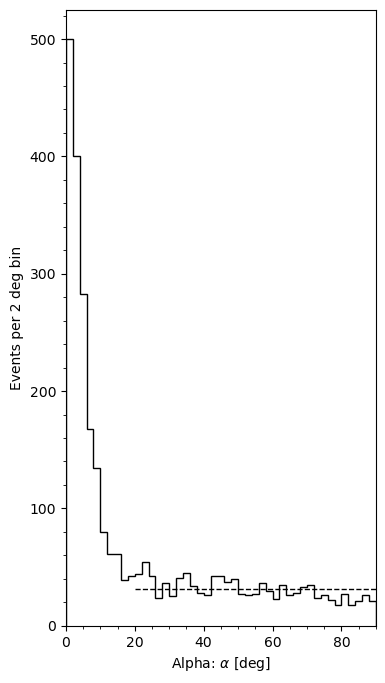

In [19]:
matplotlib.pyplot.figure(figsize=(4,8))
hy, hx, hh = matplotlib.pyplot.hist(alpha,numpy.arange(0,90.01,2),lw=1,color='k',histtype='step')
matplotlib.pyplot.xlabel('Alpha: $\\alpha$ [deg]')
matplotlib.pyplot.ylabel('Events per 2 deg bin')
matplotlib.pyplot.xlim(0,90)
matplotlib.pyplot.minorticks_on()
off_lo = 20
off_hi = 90
noff = numpy.count_nonzero((off_lo<=alpha) & (alpha<=off_hi))/(off_hi-off_lo)*2
matplotlib.pyplot.hlines(noff,off_lo,off_hi,ls='--',color='k',lw=1)

# Calculate the significance

**Note:** we do not have the correct tracking ratio (the expected value of *non/noff* when no signal is present). Here we simply assume the alpha plot is flat.

In [20]:
def li_and_ma(n_on, n_off, on_off_ratio):
    """
    Compute Li & Ma significance (Eq. 17, ApJ 272, 317, 1983).

    Parameters
    ----------
    n_on : float or int
        Number of counts in the ON region.
    n_off : float or int
        Number of counts in the OFF region.
    on_off_ratio : float
        Normalization factor (exposure ratio ON/OFF).

    Returns
    -------
    float
        Li & Ma significance (signed, positive for excess).
    """
    if n_on <= 0 and n_off <= 0:
        return 0.0

    n_on = float(n_on)
    n_off = float(n_off)
    total = n_on + n_off

    if total <= 0 or on_off_ratio <= 0:
        return 0.0

    term1 = 0.0
    if n_on > 0:
        term1 = n_on * numpy.log((1 + on_off_ratio) / on_off_ratio * (n_on / total))

    term2 = 0.0
    if n_off > 0:
        term2 = n_off * numpy.log((1 + on_off_ratio) * (n_off / total))

    significance = numpy.sqrt(2.0 * (term1 + term2))

    # Give sign depending on excess or deficit
    if n_on < on_off_ratio * n_off:
        significance = -significance

    return significance


In [21]:
on_hi = 10
on_off_ratio = on_hi/(off_hi-off_lo)
non = numpy.count_nonzero(alpha<on_hi)
noff = numpy.count_nonzero((off_lo<=alpha) & (alpha<=off_hi))
print(f'Li and Ma significance: {li_and_ma(non, noff, on_off_ratio):.2f}')

Li and Ma significance: 54.40
